# Urban Change Detection in New Delhi using Sentinel-1 SAR Data

This notebook demonstrates urban change detection in a developing area of New Delhi using Sentinel-1 SAR data accessed through the openEO API. We'll compare backscatter values between two time periods to identify urban development changes.

## Requirements
- SAR4CET toolkit (will be installed below)
- openEO Python client
- Copernicus Dataspace account for authentication
- xarray, matplotlib, numpy for data processing and visualization

## 0. Setup and Installation

First, let's clone the SAR4CET repository and install all required dependencies.

In [1]:
# Clone the SAR4CET repository
import os
import subprocess
import sys

# Check if SAR4CET directory already exists
if not os.path.exists('SAR4CET'):
    print('Cloning SAR4CET repository...')
    result = subprocess.run(['git', 'clone', 'https://github.com/naikp13/SAR4CET.git'],
                          capture_output=True, text=True)
    if result.returncode == 0:
        print('Repository cloned successfully!')
    else:
        print(f'Error cloning repository: {result.stderr}')
else:
    print('SAR4CET directory already exists.')

Cloning SAR4CET repository...
Repository cloned successfully!


In [2]:
# Install requirements from requirements.txt
print('Installing SAR4CET requirements...')

# Change to SAR4CET directory and install requirements
if os.path.exists('SAR4CET/requirements.txt'):
    result = subprocess.run([sys.executable, '-m', 'pip', 'install', '-r', 'SAR4CET/requirements.txt'],
                          capture_output=True, text=True)
    if result.returncode == 0:
        print('Requirements installed successfully!')
        print('Installed packages from requirements.txt')
    else:
        print(f'Error installing requirements: {result.stderr}')
        print('Trying to install individual packages...')
        # Try installing key packages individually
        key_packages = ['openeo>=0.22.0', 'xarray>=0.19.0', 'numpy>=1.20.0',
                       'matplotlib>=3.4.0', 'rasterio>=1.2.0']
        for package in key_packages:
            subprocess.run([sys.executable, '-m', 'pip', 'install', package])
else:
    print('requirements.txt not found, installing key packages manually...')
    key_packages = ['openeo>=0.22.0', 'xarray>=0.19.0', 'numpy>=1.20.0',
                   'matplotlib>=3.4.0', 'rasterio>=1.2.0']
    for package in key_packages:
        subprocess.run([sys.executable, '-m', 'pip', 'install', package])

Installing SAR4CET requirements...
Requirements installed successfully!
Installed packages from requirements.txt


In [3]:
# Add SAR4CET to Python path for imports
import sys
import os

# Add SAR4CET directory to Python path
sar4cet_path = os.path.abspath('SAR4CET')
if sar4cet_path not in sys.path:
    sys.path.insert(0, sar4cet_path)
    print(f'Added {sar4cet_path} to Python path')

# Verify installation by importing key modules
try:
    import openeo
    import xarray as xr
    import matplotlib.pyplot as plt
    import numpy as np
    print('All required packages imported successfully!')
    print(f'openEO version: {openeo.__version__}')
    print(f'xarray version: {xr.__version__}')
except ImportError as e:
    print(f'Import error: {e}')
    print('Please install missing packages manually.')

Added /content/SAR4CET to Python path
All required packages imported successfully!
openEO version: 0.43.0
xarray version: 2025.1.1


## Import Required Libraries

Now let's import all the libraries we'll need for the analysis.

In [4]:
import openeo
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Optional: Import SAR4CET modules if available
try:
    from sar4cet import preprocessing, visualization
    print('SAR4CET modules imported successfully!')
except ImportError:
    print('SAR4CET modules not available, using standalone approach.')

SAR4CET modules imported successfully!


## 1. Connect to openEO Backend

Connect to the Copernicus Dataspace openEO backend and authenticate.

In [5]:
# Connect to Copernicus Dataspace openEO backend
backend = "openeo.dataspace.copernicus.eu"
conn = openeo.connect(backend).authenticate_oidc()
print(f"Connected to {backend}")

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=VISH-MNXE 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
Connected to openeo.dataspace.copernicus.eu


## 2. Define Area of Interest

We'll focus on a developing area in South Delhi, specifically around Gurgaon-Delhi border where significant urban expansion has occurred.

In [6]:
# Area of Interest: Developing area in South Delhi (Gurgaon-Delhi border)
# This area has seen significant urban development in recent years
spatial_extent = {
    "west": 77.0500,
    "east": 77.1200,
    "south": 28.4200,
    "north": 28.4800,
    "crs": "EPSG:4326",
}

print(f"Area of Interest: {spatial_extent}")

Area of Interest: {'west': 77.05, 'east': 77.12, 'south': 28.42, 'north': 28.48, 'crs': 'EPSG:4326'}


## 3. Load Sentinel-1 Data for Two Time Periods

We'll compare data from two different years to detect urban changes. The first period represents the baseline (2020) and the second period represents recent development (2023).

In [8]:
# Define temporal extents for change detection
# Period 1: Baseline (2020)
temporal_extent_1 = ["2020-01-01", "2020-03-31"]

# Period 2: Recent (2023)
temporal_extent_2 = ["2023-01-01", "2023-03-31"]

print(f"Baseline period: {temporal_extent_1}")
print(f"Recent period: {temporal_extent_2}")

Baseline period: ['2020-01-01', '2020-03-31']
Recent period: ['2023-01-01', '2023-03-31']


In [9]:
# Load Sentinel-1 data for baseline period
s1_baseline = conn.load_collection(
    "SENTINEL1_GRD",
    spatial_extent=spatial_extent,
    bands=["VV", "VH"],
    temporal_extent=temporal_extent_1,
    properties={"sat:orbit_state": lambda od: od == "ASCENDING"},
)

# Load Sentinel-1 data for recent period
s1_recent = conn.load_collection(
    "SENTINEL1_GRD",
    spatial_extent=spatial_extent,
    bands=["VV", "VH"],
    temporal_extent=temporal_extent_2,
    properties={"sat:orbit_state": lambda od: od == "ASCENDING"},
)

print("Sentinel-1 data loaded for both periods")

Sentinel-1 data loaded for both periods


## 4. Apply SAR Backscatter Processing

Apply radiometric calibration and convert to dB scale for both time periods.

In [10]:
# Apply SAR backscatter processing for baseline period
s1_scatter_baseline = s1_baseline.sar_backscatter(
    coefficient="sigma0-ellipsoid",
    elevation_model="COPERNICUS_30"
)
s1bs_baseline = s1_scatter_baseline.apply(lambda x: 10 * x.log(base=10))

# Apply SAR backscatter processing for recent period
s1_scatter_recent = s1_recent.sar_backscatter(
    coefficient="sigma0-ellipsoid",
    elevation_model="COPERNICUS_30"
)
s1bs_recent = s1_scatter_recent.apply(lambda x: 10 * x.log(base=10))

print("SAR backscatter processing applied to both periods")

SAR backscatter processing applied to both periods


## 5. Temporal Aggregation

Aggregate the data temporally to create median composites for each period, reducing noise and cloud effects.

In [11]:
# Create median composites for each period
s1_baseline_median = s1bs_baseline.median_time()
s1_recent_median = s1bs_recent.median_time()

print("Temporal aggregation completed")

Temporal aggregation completed


## 6. Download Processed Data

Download the processed SAR data for both time periods.

In [13]:
# Download baseline data
print("Downloading baseline data...")
s1_baseline_median.download("new_delhi_baseline_2020.nc")

# Download recent data
print("Downloading recent data...")
s1_recent_median.download("new_delhi_recent_2023.nc")

print("Data download completed")

Data download completed


## 7. Load and Visualize Downloaded Data

Load the downloaded NetCDF files and visualize the SAR backscatter data.

In [14]:
# Load the downloaded data
baseline_data = xr.open_dataset("new_delhi_baseline_2020.nc")
recent_data = xr.open_dataset("new_delhi_recent_2023.nc")

print("Baseline data shape:", baseline_data.dims)
print("Recent data shape:", recent_data.dims)
print("\nBaseline data info:")
print(baseline_data)

Baseline data shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Recent data shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})

Baseline data info:
<xarray.Dataset> Size: 4MB
Dimensions:  (x: 698, y: 678)
Coordinates:
  * x        (x) float64 6kB 7.007e+05 7.007e+05 ... 7.076e+05 7.077e+05
  * y        (y) float64 5kB 3.152e+06 3.152e+06 ... 3.145e+06 3.145e+06
Data variables:
    crs      |S1 1B ...
    VV       (y, x) float32 2MB ...
    VH       (y, x) float32 2MB ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform


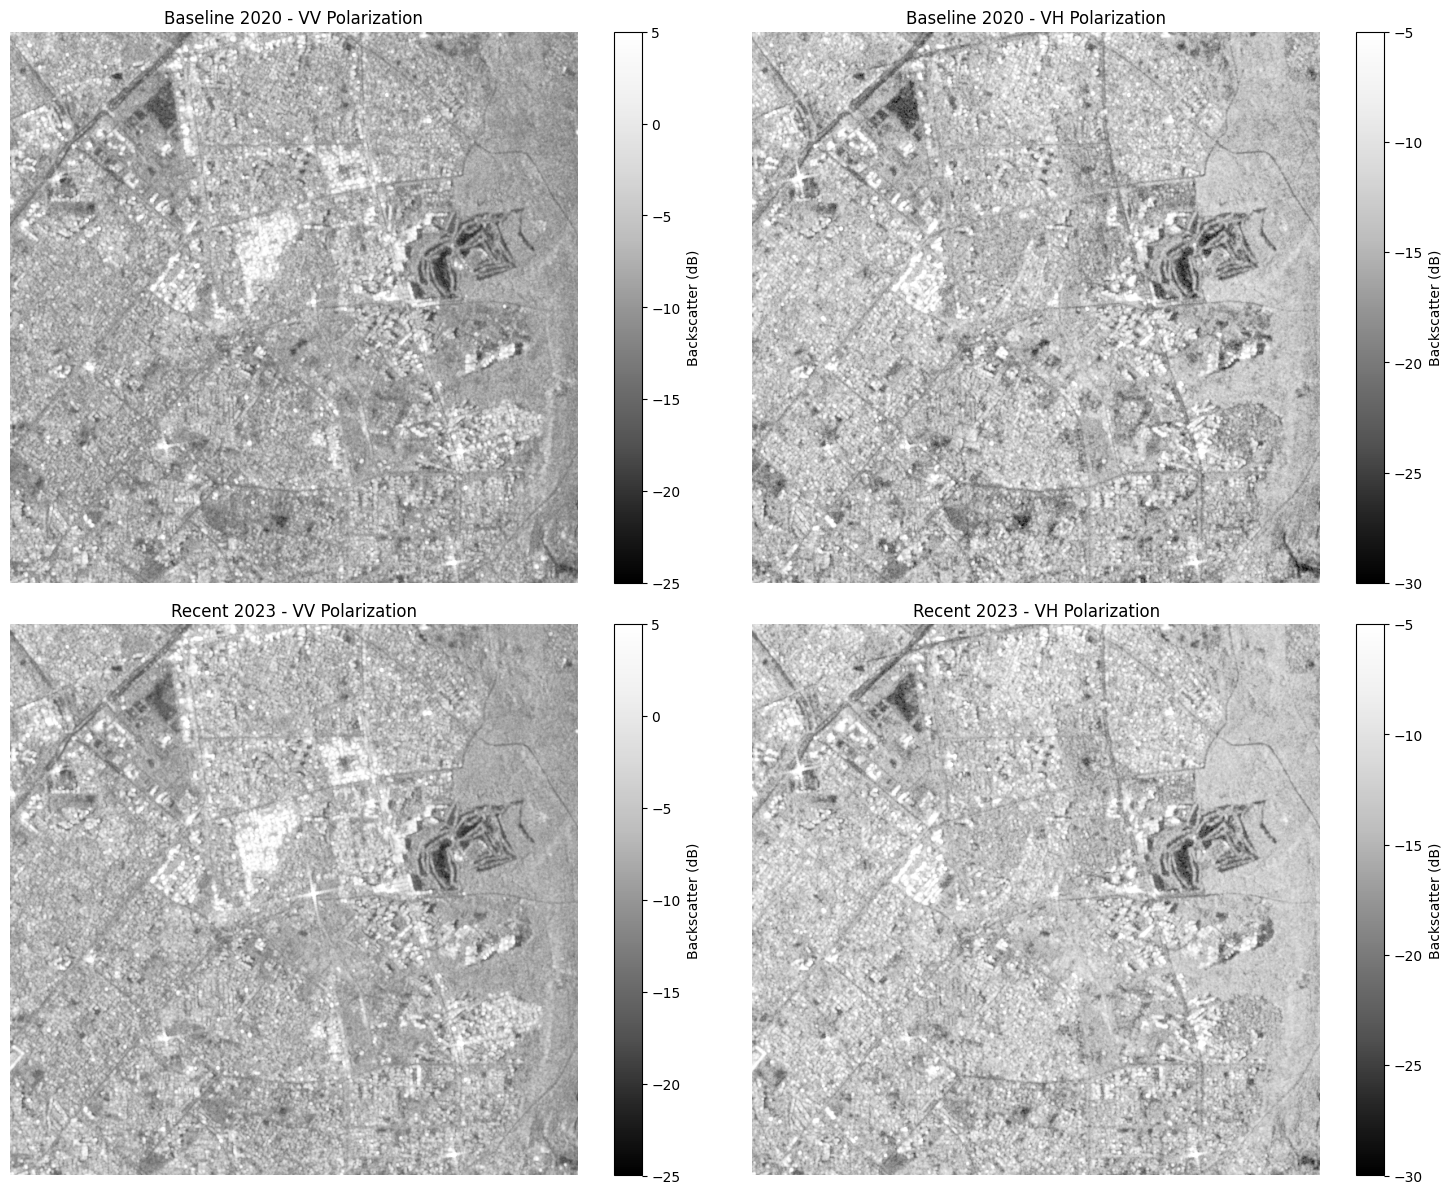

In [15]:
# Visualize VV and VH polarizations for both periods
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Baseline period
im1 = axes[0, 0].imshow(baseline_data.VV.values, cmap='Greys_r', vmin=-25, vmax=5)
axes[0, 0].set_title('Baseline 2020 - VV Polarization')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], label='Backscatter (dB)')

im2 = axes[0, 1].imshow(baseline_data.VH.values, cmap='Greys_r', vmin=-30, vmax=-5)
axes[0, 1].set_title('Baseline 2020 - VH Polarization')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], label='Backscatter (dB)')

# Recent period
im3 = axes[1, 0].imshow(recent_data.VV.values, cmap='Greys_r', vmin=-25, vmax=5)
axes[1, 0].set_title('Recent 2023 - VV Polarization')
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0], label='Backscatter (dB)')

im4 = axes[1, 1].imshow(recent_data.VH.values, cmap='Greys_r', vmin=-30, vmax=-5)
axes[1, 1].set_title('Recent 2023 - VH Polarization')
axes[1, 1].axis('off')
plt.colorbar(im4, ax=axes[1, 1], label='Backscatter (dB)')

plt.tight_layout()
plt.show()

## 8. Change Detection Analysis

Calculate the difference between the two time periods to identify areas of change. Urban development typically shows increased backscatter values due to the presence of buildings and infrastructure.

In [16]:
# Calculate change detection (difference between recent and baseline)
vv_change = recent_data.VV.values - baseline_data.VV.values
vh_change = recent_data.VH.values - baseline_data.VH.values

# Calculate statistics
print(f"VV Change Statistics:")
print(f"  Mean: {np.nanmean(vv_change):.3f} dB")
print(f"  Std: {np.nanstd(vv_change):.3f} dB")
print(f"  Min: {np.nanmin(vv_change):.3f} dB")
print(f"  Max: {np.nanmax(vv_change):.3f} dB")

print(f"\nVH Change Statistics:")
print(f"  Mean: {np.nanmean(vh_change):.3f} dB")
print(f"  Std: {np.nanstd(vh_change):.3f} dB")
print(f"  Min: {np.nanmin(vh_change):.3f} dB")
print(f"  Max: {np.nanmax(vh_change):.3f} dB")

VV Change Statistics:
  Mean: 0.830 dB
  Std: 2.151 dB
  Min: -21.017 dB
  Max: 23.693 dB

VH Change Statistics:
  Mean: 0.731 dB
  Std: 2.013 dB
  Min: -12.803 dB
  Max: 23.059 dB


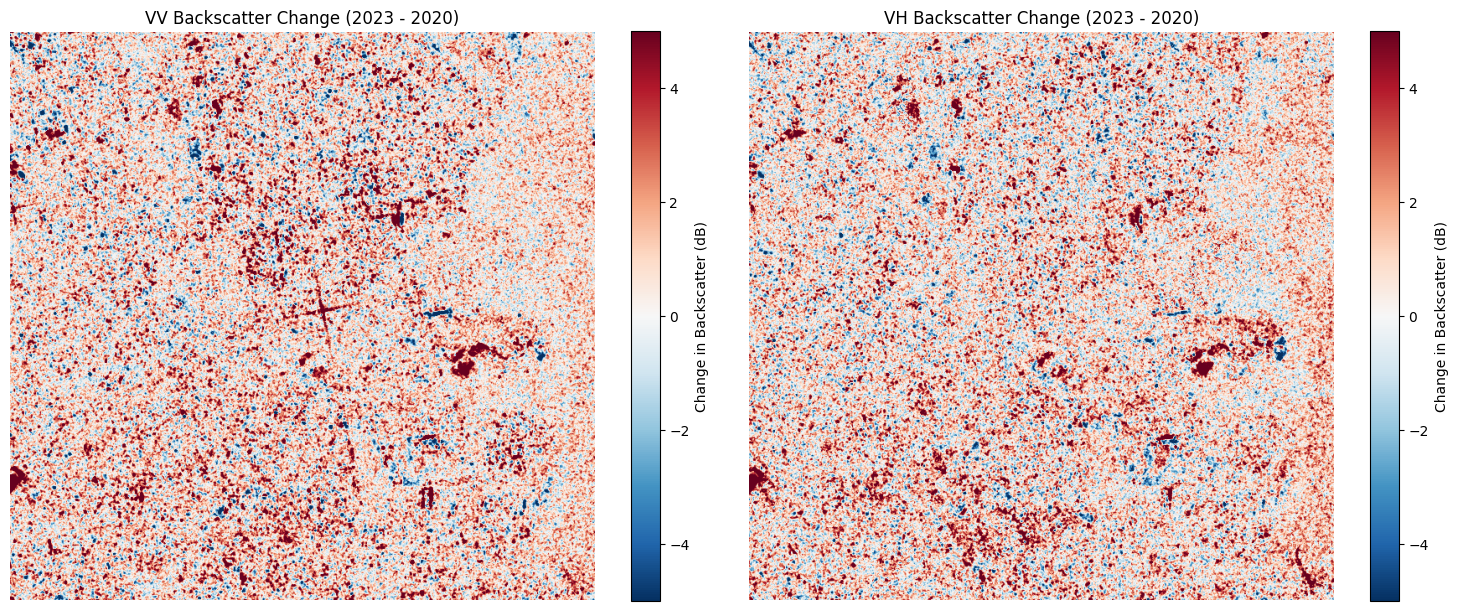


Interpretation:
- Red areas: Increased backscatter (potential urban development)
- Blue areas: Decreased backscatter (potential vegetation loss or water bodies)
- White areas: No significant change


In [17]:
# Visualize change detection results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# VV change
im1 = axes[0].imshow(vv_change, cmap='RdBu_r', vmin=-5, vmax=5)
axes[0].set_title('VV Backscatter Change (2023 - 2020)')
axes[0].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[0], label='Change in Backscatter (dB)')

# VH change
im2 = axes[1].imshow(vh_change, cmap='RdBu_r', vmin=-5, vmax=5)
axes[1].set_title('VH Backscatter Change (2023 - 2020)')
axes[1].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[1], label='Change in Backscatter (dB)')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Red areas: Increased backscatter (potential urban development)")
print("- Blue areas: Decreased backscatter (potential vegetation loss or water bodies)")
print("- White areas: No significant change")

## 9. Urban Change Detection Mask

Create a binary mask to identify significant urban changes based on backscatter increase thresholds.

In [18]:
# Define thresholds for urban change detection
# Urban development typically shows increase in VV backscatter > 2 dB
vv_threshold = 2.0  # dB
vh_threshold = 1.5  # dB

# Create urban change masks
urban_change_vv = vv_change > vv_threshold
urban_change_vh = vh_change > vh_threshold

# Combined urban change mask (both polarizations show increase)
urban_change_combined = urban_change_vv & urban_change_vh

# Calculate change statistics
total_pixels = vv_change.size
changed_pixels_vv = np.sum(urban_change_vv)
changed_pixels_vh = np.sum(urban_change_vh)
changed_pixels_combined = np.sum(urban_change_combined)

print(f"Urban Change Detection Results:")
print(f"  Total pixels: {total_pixels}")
print(f"  VV change pixels: {changed_pixels_vv} ({changed_pixels_vv/total_pixels*100:.2f}%)")
print(f"  VH change pixels: {changed_pixels_vh} ({changed_pixels_vh/total_pixels*100:.2f}%)")
print(f"  Combined change pixels: {changed_pixels_combined} ({changed_pixels_combined/total_pixels*100:.2f}%)")

Urban Change Detection Results:
  Total pixels: 473244
  VV change pixels: 111782 (23.62%)
  VH change pixels: 148751 (31.43%)
  Combined change pixels: 55494 (11.73%)


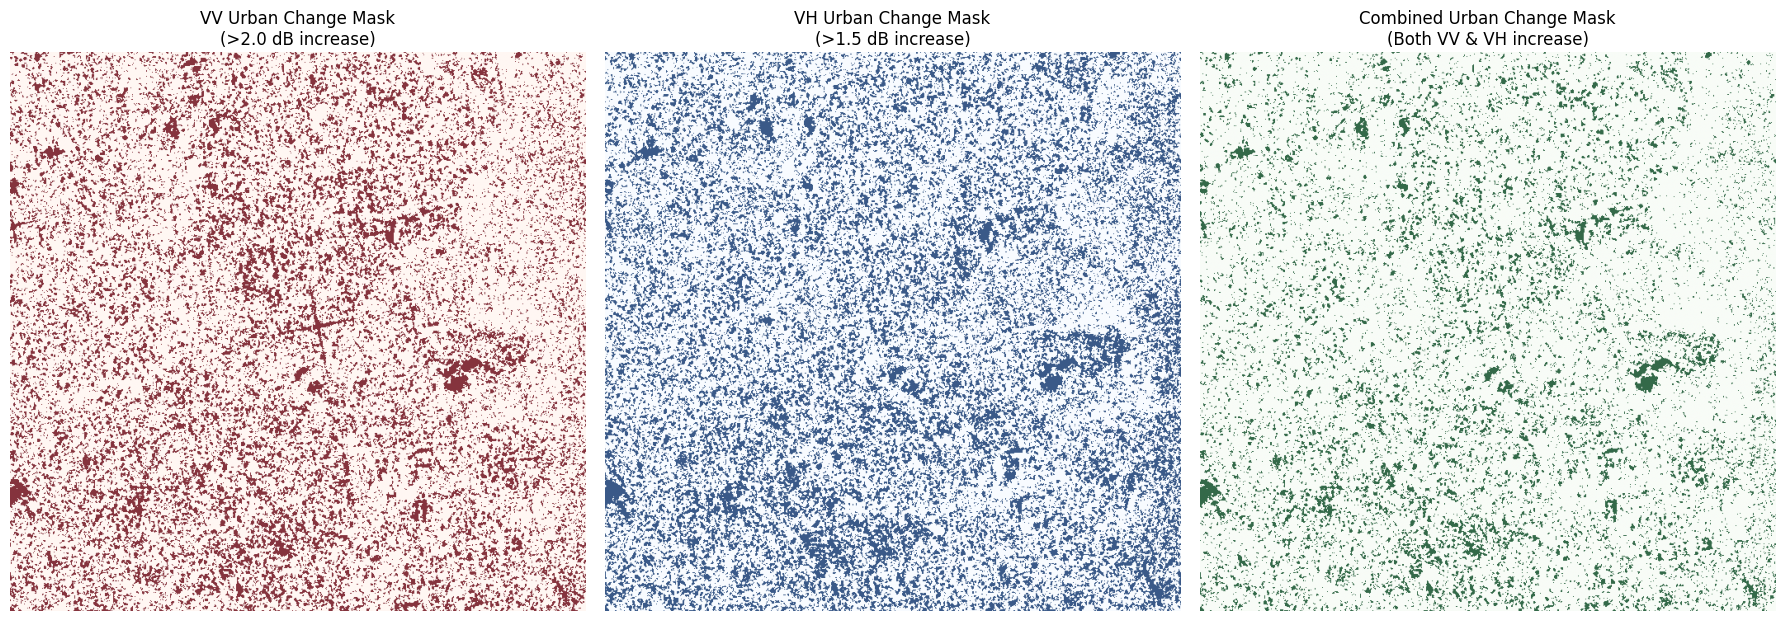

In [19]:
# Visualize urban change masks
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# VV urban change mask
axes[0].imshow(urban_change_vv, cmap='Reds', alpha=0.8)
axes[0].set_title(f'VV Urban Change Mask\n(>{vv_threshold} dB increase)')
axes[0].axis('off')

# VH urban change mask
axes[1].imshow(urban_change_vh, cmap='Blues', alpha=0.8)
axes[1].set_title(f'VH Urban Change Mask\n(>{vh_threshold} dB increase)')
axes[1].axis('off')

# Combined urban change mask
axes[2].imshow(urban_change_combined, cmap='Greens', alpha=0.8)
axes[2].set_title('Combined Urban Change Mask\n(Both VV & VH increase)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

This analysis demonstrates urban change detection using Sentinel-1 SAR data accessed through the openEO API. The key findings include:

1. **Data Access**: Successfully accessed Sentinel-1 GRD data for New Delhi using openEO
2. **Processing**: Applied SAR backscatter calibration and temporal aggregation
3. **Change Detection**: Identified areas with significant backscatter increases indicating potential urban development
4. **Visualization**: Created comprehensive visualizations showing changes between 2020 and 2023

### Key Advantages of openEO for SAR Processing:
- **Standardized Processing**: Consistent SAR backscatter calibration across different sensors
- **Cloud Processing**: No need to download large datasets for processing
- **Temporal Analysis**: Easy temporal aggregation and comparison
- **Scalability**: Can be easily extended to larger areas or longer time series

### Urban Change Detection Insights:
- Increased VV backscatter typically indicates new buildings or infrastructure
- VH polarization is sensitive to vegetation changes and urban texture
- Combined analysis provides more robust change detection results

### Next Steps:
- Validate results with high-resolution optical imagery
- Extend analysis to longer time series for trend analysis
- Incorporate additional SAR parameters (coherence, polarimetric features)
- Apply machine learning techniques for automated urban change classification

In [ ]:
# Clean up downloaded files (optional)
import os

# Uncomment the following lines to remove downloaded files
# os.remove('new_delhi_baseline_2020.nc')
# os.remove('new_delhi_recent_2023.nc')
# print('Downloaded files cleaned up')

print('Analysis completed successfully!')